In [1]:
import os
import sys
from glob import glob
# 이 파일의 Directory의 절대 경로
__file__path = os.path.abspath("")
print(__file__path)
sys.path.append(__file__path)

import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset

# Configuration 
from omegaconf import DictConfig, OmegaConf
import hydra
config_path = "./configs"
config_name = "config.yaml"
try: hydra.initialize(version_base=None, 
                      config_path=config_path)
except: pass
cfg = hydra.compose(config_name=config_name)
print(OmegaConf.to_yaml(cfg))

/Users/kackaobank1/Desktop/dev/FaceSwap/swappers/SmoothSwap
train:
  isTrain: false
  end_epoch: 1000
  batch_size: 512
  optimizer: adam
  weight_decay: 0.0005
  momentum: 0.9
  lr: 0.001
  lr_step: 10
  log_dir: ./logs
  checkpoint_dir: ./checkpoints
  device: cpu
id_emb:
  image_size: 224
  train_embedder: false
  network: resnet50
  emb_size: 512
  checkpoint_path: ''
generator:
  image_size: 256
  num_feature_init: 64
discriminator:
  image_size: 256
authur:
  name: conor.k
  version: 0.0.1



/Users/kackaobank1/.pyenv/versions/3.8.10/envs/python3.8/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


#### Fix random seed

In [2]:
random_seed = 777
torch.manual_seed(random_seed)
np.random.seed(random_seed)
import random
random.seed(random_seed)

In [3]:
#### model build test
# !python ./models/id_emb.py
# from models.id_emb import IdEmbedder
# embedder = IdEmbedder(cfg)

In [4]:
from models.id_emb import IdEmbedder

class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)

#### Dataloader

In [5]:
# train_test_split 
# data_dir => train_data_dir, test_data_dir

def get_train_test_set_vggface(data_dir, ratio_of_test=0.3):
    """
    example
        data_dir = "../../data/vggface2_crop_arcfacealign_224/"
    """
    all_pictures = glob(data_dir+"/*/*.jpg")

    test_size = int(len(all_pictures) * ratio_of_test)

    test_set = np.random.choice(all_pictures, size=test_size)
    train_set = list(set(all_pictures) - set(test_set))
    
    return np.array(train_set), test_set

def get_label_dict_vggface(data_dir):
    all_label = glob(data_dir+"/*")
    return {os.path.basename(name) : label for label, name in enumerate(all_label)}


In [6]:
from torch.utils.data import Dataset
from PIL import Image

class VGGFace2Dataset(Dataset):
    def __init__(self, data_set, label_dict, transform=None):
        self.data_set = data_set
        self.label_dict = label_dict
        self.label_dict_inv = {v:k for k, v in label_dict.items()}
        self.label_keys = list(label_dict.keys())
        self.transform = transform
        
    def __len__(self):
        return len(self.data_set)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_path = self.data_set[idx]
        
        img_dir = os.path.dirname(img_path)
        id_idx = os.path.basename(img_dir)
        label = self.label_dict[id_idx]
        
        img1 = Image.open(img_path)

        if self.transform is not None:
            img1 = self.transform(img1)

        return img1, label

def test_VGGFace2Dataset(data_set, label_dict):
    import matplotlib.pyplot as plt     
    vgg_dataset = VGGFace2Dataset(data_set, label_dict)
    
    plot_id = 1
    for i in np.random.randint(len(vgg_dataset), size=3):
        plt.subplot(1,3,plot_id)
        plot_id += 1
        sample, label = vgg_dataset[i]
        plt.title(vgg_dataset.label_dict_inv[label])
        plt.imshow(sample)
    plt.tight_layout()
    plt.show()


# Change checkpoint path 

In [12]:
checkpoint_path = "./checkpoints/id_emb/cpt_50_0.1424.tar"

In [8]:
data_dir = "../../data/vggface2_crop_arcfacealign_224/"
batch_size = 8
max_sample_batch_n = 100

if torch.cuda.is_available():
    embedder = torch.load(checkpoint_path)["model"].embedding_net
else:
    embedder = torch.load(checkpoint_path, map_location=torch.device('cpu'))["model"].embedding_net
    
    
transform = transforms.Compose([
    transforms.ToTensor()
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [9]:
label_dict = get_label_dict_vggface(data_dir)
train_set, test_set = get_train_test_set_vggface(data_dir, 0.2)
# test_VGGFace2Dataset(train_set, label_dict)

test_dataset  = VGGFace2Dataset(test_set,  label_dict, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=False)

embeddings = []
for batch_idx, sample in enumerate(test_loader):
    imgs, labels = sample
    with torch.no_grad():
        emb = embedder(imgs).detach().numpy()
        
    embeddings += [e for e in emb]
    
    if batch_idx > max_sample_batch_n: 
        break
        
embeddings = np.array(embeddings)
sim_matrix = np.dot(embeddings, embeddings.T)

In [10]:
import matplotlib.pyplot as plt

def top_k_img_show(test_set, sim_matrix, idx=None, k=10):
    if idx is None:
        idx = np.random.randint(sim_matrix.shape[0])
    
    src_img = test_set[idx]
    sim_vec = sim_matrix[idx]
    
    top_k = np.argsort(sim_vec)[-k:]
    
    plt.figure(figsize=(12, 20))
    top_k_ids = []
    for pi, i in enumerate(reversed(top_k)):
        
        plt.subplot(1, k, pi+1)
        top_k_id = os.path.basename(os.path.dirname(test_set[i]))
        top_k_ids.append(top_k_id)
        
        plt.title(top_k_id)
        plt.imshow(Image.open(test_set[i]))
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()
    
    identity = os.path.basename(os.path.dirname(test_set[idx]))
    num_of_same_person = len([sample for sample in test_set if identity in sample])
    num_of_same_person_in_the_top_k = len([x for x in top_k_ids if identity == x])
    print(f"{identity} : {num_of_same_person} images of same person are in the test set.")
    print(f"and {num_of_same_person_in_the_top_k} samples are in the top-k.")


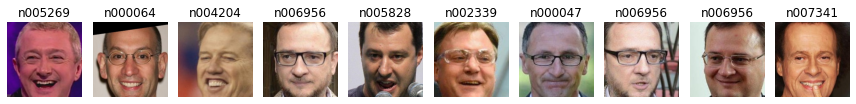

n005269 : 53 images of same person are in the test set.
and 1 samples are in the top-k.


In [11]:
top_k_img_show(test_set, sim_matrix, idx=None, k=10)